In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from astropy import wcs
import astropy.units as u
import matplotlib as mpl
import os
from astropy.cosmology import Planck15 as cosmo
from scipy import ndimage
import corner 
# import coop_post_processing as cpp
# set plot params
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 10})
import matplotlib.gridspec as gridspec


In [2]:
def ThetaPhitoDeclRa(theta,phi):
    dec = -1*np.degrees(theta)+90
    ra  = np.degrees(phi)
    if ra>180:
        ra = -360+ra
    return dec,ra

def get_x_e(e_filename, ra, dec, mask=None):
    ecc_map0 = hp.read_map(e_filename, field=0)
    ecc_map1 = hp.read_map(e_filename, field=1)    
    ecc_map2 = hp.read_map(e_filename, field=2)
    
    pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
    e  = np.sqrt((ecc_map1**2 + ecc_map2**2)/(2*ecc_map0**2))
    #ecc_map0 = del^2(F)
    if mask is None:
        mean_del2 = sum(ecc_map0)/ecc_map0.size
        rms_2 = np.sqrt(sum((ecc_map0-mean_del2)**2)/ecc_map0.size)
        x = ecc_map0 / rms_2
    else:
        mean_del2 = sum(ecc_map0*mask)/sum(mask)
        rms_2 = np.sqrt(sum((ecc_map0-mean_del2)**2*mask)/sum(mask))
        x = ecc_map0*mask / rms_2
    hp.mollview(ecc_map0)
    print("mean of del^2(F) = ", mean_del2)
    print("rms of del^2(F)  = ", rms_2)

    print("Map of x = del^2(F)")
    hp.mollview(x)
    return e[pixels], x[pixels]

def get_nu(od_filename, ra, dec, mask=None):
    pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
    od_map = read_amp_map(od_filename)
    if mask is not None:
        mean_od = sum(od_map*mask)/sum(mask)
        rms = np.sqrt(sum((od_map-mean_od)**2*mask)/sum(mask))
    else:
        mean_od = sum(od_map)/od_map.size
        rms = np.sqrt(sum((od_map-mean_od)**2)/od_map.size)
    print("rms = ", rms)
    print("mean of overdensity map = ", mean_od)
    if mask is not None:
        nu = ((od_map-mean_od)*mask) / rms
    else:
        nu = (od_map-mean_od)/rms
    hp.mollview(nu)
    return(nu[pixels])
    
def map_to_overdensity(map, mask):
    map_mean = sum(map*mask)/sum(mask)
    print("map mean before: ", map_mean)
    omap = map/map_mean - 1
    print("map mean after: ", sum(omap*mask)/sum(mask))
    return omap*mask

def nu_custom_scale(od_map_file, fwhm, ra, dec, mask):
    od_map = hp.read_map(od_map_file)
    od_map_smth = hp.smoothing(od_map, fwhm=(fwhm.to(u.rad)).value, pol=False)
    pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
    mean_od = sum(od_map_smth*mask)/sum(mask)
    rms = np.sqrt(sum((od_map_smth-mean_od)**2*mask)/sum(mask))
    print("rms = ", rms)
    print("mean of overdensity map = ", mean_od)
    nu = ((od_map_smth-mean_od)*mask) / rms
    hp.mollview(nu)
    return(nu[pixels])

def get_peakinfo(filename):
    peakfile = fits.open(filename)
    peakinfo = peakfile[0].data
    rot_angle = peakinfo[:,3]
    theta,phi = peakinfo[:,1], peakinfo[:,2]
    dec = []
    ra  = []
    for i in range(len(theta)):
        dec.append(ThetaPhitoDeclRa(theta[i],phi[i])[0])
        ra.append(ThetaPhitoDeclRa(theta[i],phi[i])[1])

    ra = np.asarray(ra)
    dec = np.asarray(dec)
#     in_region = (ra>pt_lonmin) & (ra < pt_lonmax) & (dec < pt_latmax) & (dec > pt_latmin)
#     dec = dec[in_region]
#     rot_angle = rot_angle[in_region]
#     ra = ra[in_region]
    return (rot_angle,ra,dec)
    peakfile.close()
    

def get_vector_components(rot_angle):
    U_arr = np.zeros(len(rot_angle))
    V_arr = np.zeros(len(rot_angle))
    m = 0
    for r in rot_angle:

        if (r <= np.pi/2.) or (r > 3*np.pi/2.):
            U = 1/np.sqrt(1+np.tan(r)**2)
        else:
            U = -1/np.sqrt(1+np.tan(r)**2)
        V = U * np.tan(r)
        U_arr[m] = U
        V_arr[m] = V
        m += 1
    return U_arr, V_arr

def read_amp_map(amp_file):
    amp_map = fits.open(amp_file)
    amp_map[1].header['TTYPE3'] = 'ID2'
    amp_map.writeto(amp_file, overwrite=True)
    amp_map.close()
    return hp.read_map(amp_file, field=0)

In [3]:
latmin = -39
latmax = -29
lonmin = 3
lonmax = 35

pt_latmin = latmin + 0.1
pt_latmax = latmax - 0.1
pt_lonmin = lonmin + 0.1
pt_lonmax = lonmax - 0.1

In [4]:
nside=4096
h = (cosmo.H0/100.).value
thresh = False
custom_nuscale = True
nuscale_smth = 9.4 #Mpc
zbins = [[0.15,0.35], [0.35,0.5], [0.5,0.65]]
mid = [(z[0]+z[1])/2. for z in zbins]
nuscale_arcmin = cosmo.arcsec_per_kpc_comoving(mid).to(u.arcmin/u.megaparsec)*float(nuscale_smth)/h*u.Mpc
print(nuscale_arcmin)
nuscale_arcmin_rounded = [46, 28, 21]

[45.86686236 28.26505183 21.76276102] arcmin


GRF_lambdagt10_reg0_640_1418Mpc_13pt9_gfield_pks.fits
grf_gfield_buzzardspec_zbin1_0_ECC_HESSIAN_fwhm46a.fits
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
mean of del^2(F) =  -1.127907570778556e-05
rms of del^2(F)  =  8640.679500646092
Map of x = del^2(F)
grf_gfield_buzzardspec_zbin1_0_AMPLITUDE_fwhm46a.fits
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
rms =  0.3186803831448865
mean of overdensity map =  4.242509900622855e-08
GRF_lambdagt10_reg0_1418_1945Mpc_13pt9_gfield_pks.fits
grf_gfield_buzzardspec_zbin2_0_AMPLITUDE_fwhm28a.fits
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
rms =  0.39722599275797327
mean of overdensity map =  4.687680722095084e-09
grf_gfield_buzzardsp

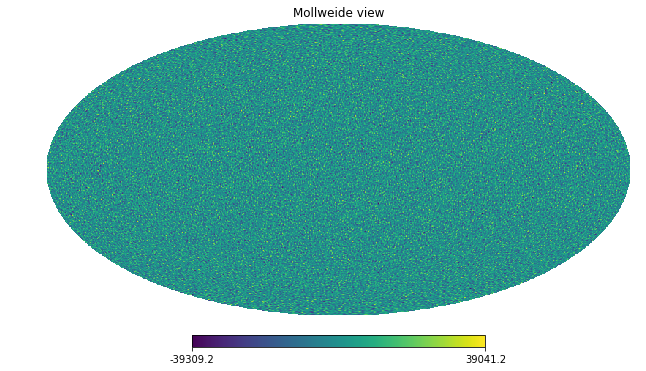

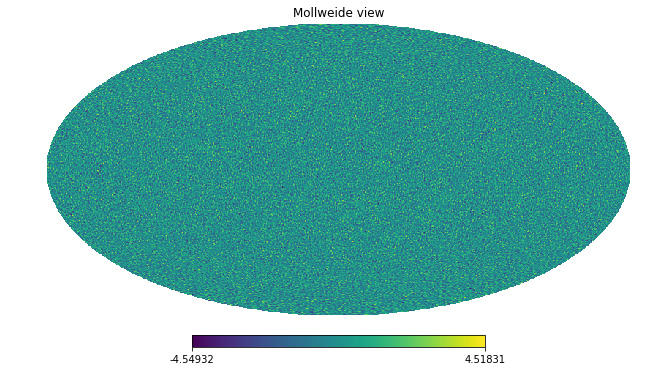

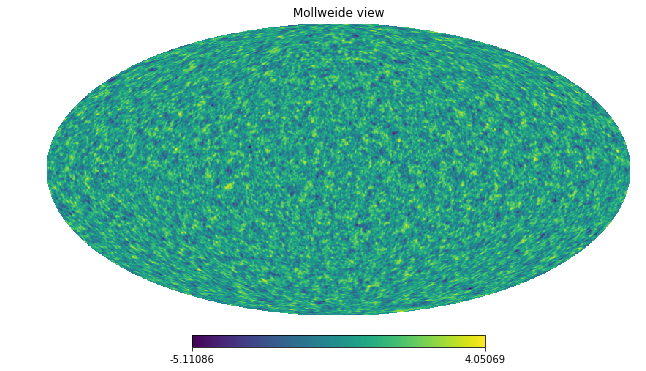

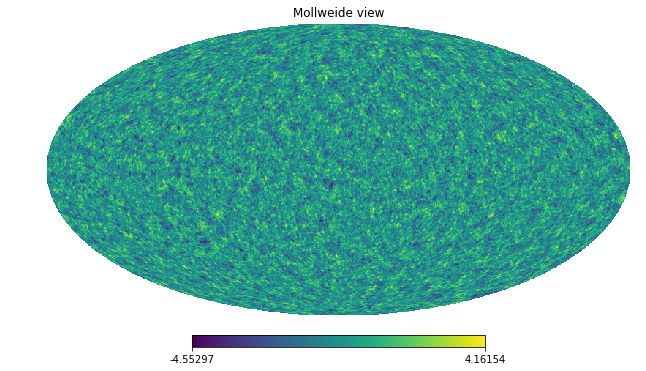

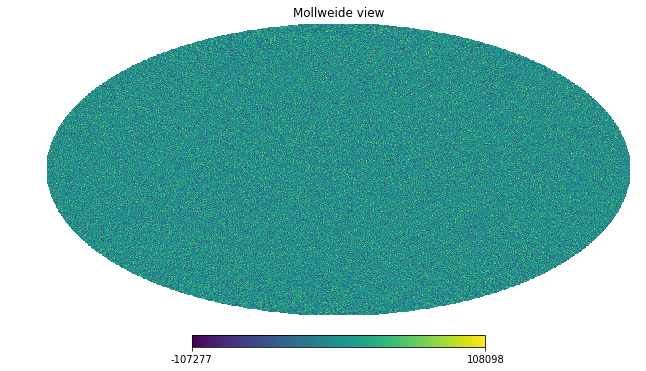

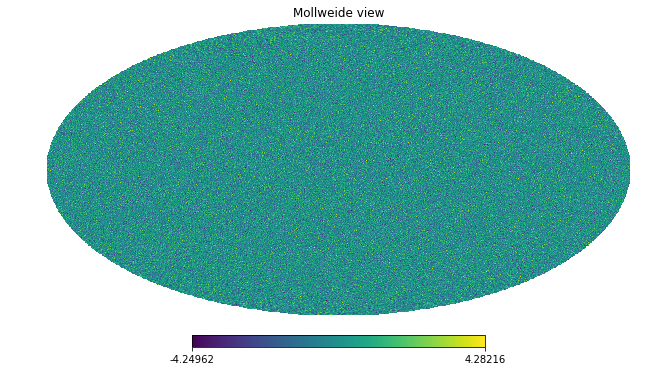

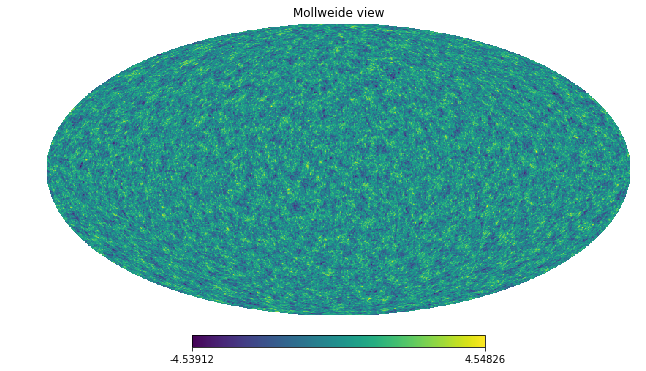

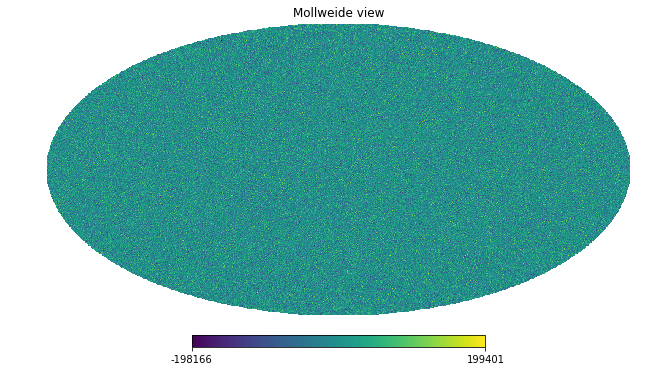

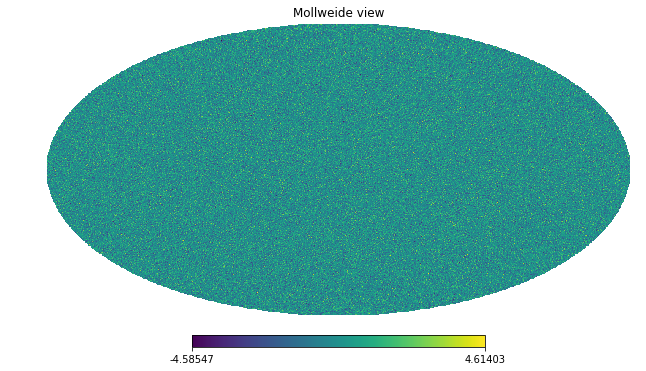

In [11]:
mode = 'GRF'
allz_peaks_info = []
if mode == 'Buzzard':
    mask = hp.read_map("/mnt/raid-cita/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")
    pks_stk_path  = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_tSZ_rmpks/"
    map_path = "/mnt/raid-cita/mlokken/buzzard/number_density_maps/des_reg/3_zbins_grf_comparison/"
#     rot_angle, ra, dec = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/Buzzard_ndmap_rmpks/peaks/redmagic_highdens_midz_od_map_alle_allnu_hess_sym_{:s}a.fits".format(smth_scale))
#     e_vals,x_vals = get_x_e("/mnt/scratch-lustre/mlokken/buzzard/number_density_maps/des_reg/buzzard_redmagic_highdens_midz_od_map_nosmooth_4096_ECC_HESSIAN_fwhm{:s}a.fits".format(smth_scale), ra, dec, mask)
#     nu_vals      = get_nu("/mnt/scratch-lustre/mlokken/buzzard/number_density_maps/des_reg/buzzard_redmagic_highdens_midz_od_map_nosmooth_4096_AMPLITUDE_fwhm{:s}a.fits".format(smth_scale), ra, dec, mask)

elif mode == 'GRF':
    pks_stk_path  = "/mnt/scratch-lustre/mlokken/stacking/GRF_buzzspec/0/"
    map_path = "/mnt/raid-cita/mlokken/GRF_buzzspec/"
    mask = None
elif mode == 'redmagic':
    mask = hp.read_map("/mnt/raid-cita/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")
    pks_stk_path  = "/mnt/scratch-lustre/mlokken/stacking/ACT+Planck/"
    map_path = "/mnt/raid-cita/mlokken/data/number_density_maps/3_zbins_grf_comparison/"
    
dbins = [[640,1418],[1418,1945],[1945,2427]]
c = 0
for d in dbins:
    for file in os.listdir(pks_stk_path):
        if str(d[0])+"_"+str(d[1]) in file and "nugt" not in file and "pks" in file and "gfield" in file and file.endswith(".fits"):
            print(file)
            rot_angle, ra, dec = get_peakinfo(os.path.join(pks_stk_path, file))
    for file2 in os.listdir(map_path):
        if 'zbin{:d}'.format(c+1) in file2:
            if "ECC" in file2:
                if mode=='GRF' and '_0_' in file2: # select the first map only
                    print(file2)
                    e_vals, x_vals = get_x_e(os.path.join(map_path,file2), ra, dec, mask)
            if "AMPLITUDE" in file2 and "{:d}".format(nuscale_arcmin_rounded[c]) in file2:
                if mode == 'GRF' and "_0_" in file2: #select the first map only
                    print(file2)
                    nu_vals = get_nu(os.path.join(map_path,file2),ra,dec)
                elif mode == 'Buzzard' or mode == 'redmagic':
                    print(file2)
                    nu_vals = get_nu(os.path.join(map_path,file2),ra,dec, mask)

    peaks_info = np.zeros((len(rot_angle), 6))
    peaks_info[:,0] = rot_angle
    peaks_info[:,1] = ra
    peaks_info[:,2] = dec
    peaks_info[:,3] = e_vals
    peaks_info[:,4] = x_vals
    peaks_info[:,5] = nu_vals

    allz_peaks_info.append(peaks_info)
    c+=1

In [13]:
zbin_choice = allz_peaks_info[1]
nu_choice = zbin_choice[:,5]
e_choice  = zbin_choice[:,3]
allowed = (nu_choice>2) & (e_choice>0.3)
x_choice = zbin_choice[:,4]
print(len(nu_choice[allowed]))

for i in range(1,4):
    np.savetxt(os.path.join(pks_stk_path, "grf_comparison_zbin{:d}_pkinfo_9pt4Mpc_gfieldpks.txt".format(i)), allz_peaks_info[i-1])

775


Stdev x = 0.99
Stdev x = 0.99
Stdev x = 1.00


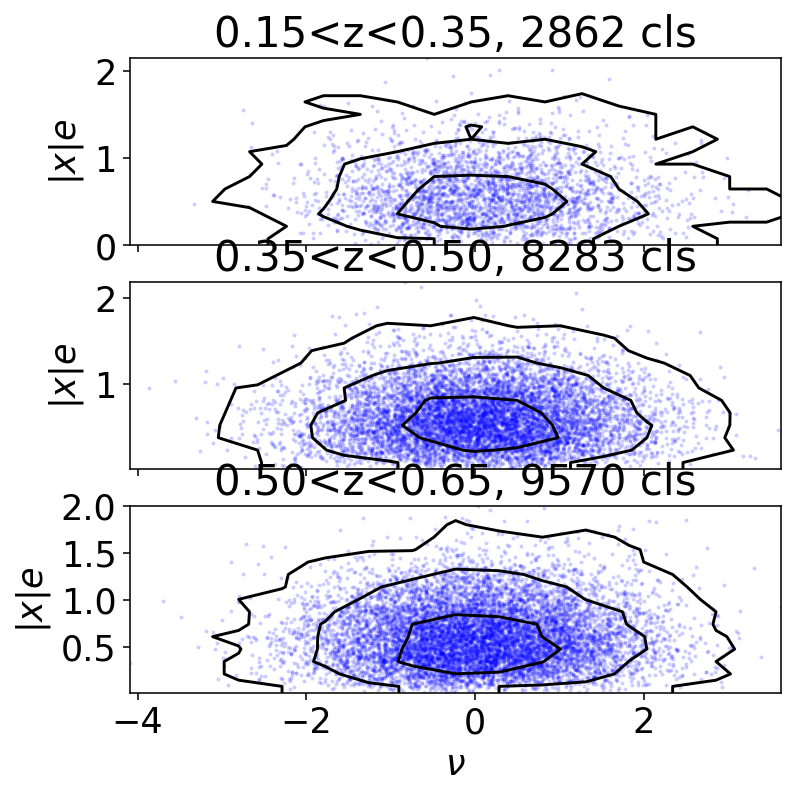

In [36]:
zrange = [[0.15,0.35], [0.35, 0.5], [0.5, 0.65]]

mpl.rcParams['figure.dpi'] = 140

fig, ax = plt.subplots(3,1, sharex=True, figsize=[6, 6])

if mode == 'redmagic':
    pks = 'rmpks'
elif mode == 'GRF':
    pks = '1Mpcpks'
elif mode == 'Buzzard':
    pks = 'mockrmpks'
for c in range(len(allz_peaks_info)):
    zbin = allz_peaks_info[c]
    e  = zbin[:,3]
    x  = zbin[:,4]
    nu = zbin[:,5]
    nu_sig = np.std(nu)
    e_sig  = np.std(e)
    print("Stdev x = {:0.2f}".format(np.std(x)))
    corner.hist2d(nu,abs(x)*e, plot_datapoints=True,  levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[c], plot_density=False, bins=15, no_fill_contours=True, color='k',  labels=[r'$\nu$',r'$|x|e$'], contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':0.2, 'color':'b'})

    ax[c].set_title("{:0.2f}<z<{:0.2f}, {:d} cls".format(zrange[c][0], zrange[c][1], len(e)))
#     ax[c].scatter(x, e*abs(x), s=3, alpha = 0.05, label=r"$x$")
#     ax[c].scatter(nu, e*abs(x), s=3, alpha = 0.05)
    if c == 2:
#         ax[c].set_xlabel(r"$x = \nabla^2 F / \sigma_2$")
        ax[c].set_xlabel(r"$\nu$")
#     ax[c].set_ylabel("$|x|e = (\lambda_1 - \lambda_2)/(4\sigma_2$)")
#     h, nuedges, eedges, image = ax[c].hist2d(x, abs(x)*e, bins=30)
#     numids = [(nuedges[i]+nuedges[i+1])/2. for i in range(len(nuedges[0:30]))]
#     emids = [(eedges[i]+eedges[i+1])/2. for i in range(len(eedges[0:30]))]



    ax[c].set_ylabel("$|x|e$")
#     ax[c].set_ylim([0,4])
#     ax[c].set_xlim([-4,10])
#     ax[c].plot([0,0],[0,4])
#     ax[c].plot([2,2],[0,4], linestyle='--', color='k')

    if thresh==True:
        thr = 'thr'
    else:
        thr = 'nothr'

# plt.savefig("/home/mlokken/actxdes_stacking/plots/field_statistics/nu_xe_{:s}_3zbins_{:s}_alldes_9pt4overh_Mpc_{:s}_smth_hess.png".format(mode, pks, thr), dpi=300)
# plt.show()

Average x = 0.04
Stdev x = 1.00


IndexError: boolean index did not match indexed array along dimension 0; dimension is 9570 but corresponding boolean dimension is 2862

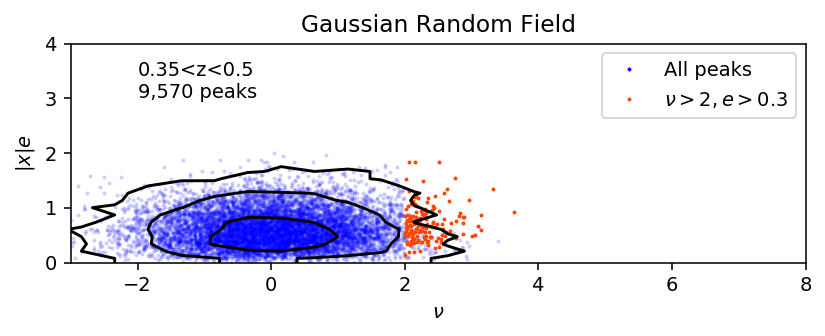

In [73]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=[6, 2.5])


print("Average x = {:0.2f}".format(np.mean(x)))
print("Stdev x = {:0.2f}".format(np.std(x)))
ax.set_title("Gaussian Random Field")
#              , {:0.2f}<z<{:0.2f}, {:,} clusters".format(mode, zrange[1][0], zrange[1][1], len(e)))
ax.text(-2, 3, "0.35<z<0.5\n{:,} peaks".format(len(e)))
corner.hist2d(nu_choice[np.invert(allowed)],abs(x_choice[np.invert(allowed)])*e_choice[np.invert(allowed)], plot_datapoints=True,  levels=(0.39, 0.86, 0.99), fig=fig, ax=ax, plot_density=False, bins=15, no_fill_contours=True, color='k',  labels=[r'$\nu$',r'$|x|e$'], contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':0.2, 'color':'b', 'label':'All peaks'})
corner.hist2d(nu_choice[allowed],abs(x_choice[allowed])*e_choice[allowed], plot_datapoints=True,  levels=(0.39, 0.86, 0.99), fig=fig, ax=ax, plot_contours=False, plot_density=False, bins=15, no_fill_contours=True, color='k',  labels=[r'$\nu$',r'$|x|e$'], contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':1, 'color':'orangered', 'label':r'$\nu>2, e>0.3$'})
ax.set_xlabel(r"$\nu$")
ax.set_ylabel("$|x|e$")
ax.set_ylim([0,4])
ax.set_xlim([-3,8])
leg = plt.legend()
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
# ax.plot([2,2],[0,4], linestyle='--', color='k')
# ax.plot([-1,10],[0.2*-1,0.2*10], linestyle='--', color='k')
if thresh==True:
    thr = 'thr'
else:
    thr = 'nothr'
plt.tight_layout()
print(len(nu[allowed_nu])/len(nu))
print(len(nu[allowed])/len(nu))
# plt.savefig("/home/mlokken/actxdes_stacking/plots/field_statistics/nu_xe_{:s}_zbin2_{:s}_alldes_9pt4overh_Mpc_{:s}_smth_hess_nu2_ept2_goodtitle_diffcol.png".format(mode, pks, thr), dpi=300)
# plt.show()

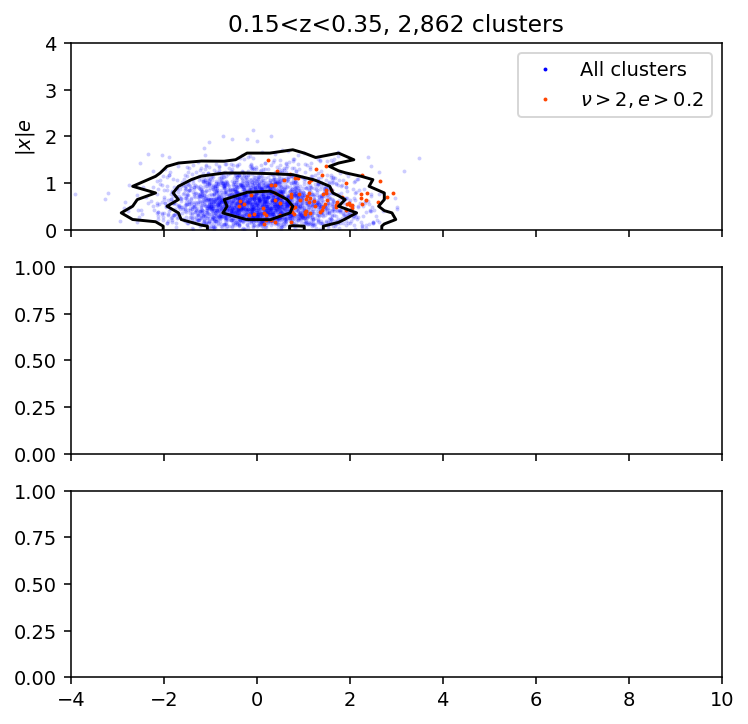

In [62]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=[6, 6])

for c in range(len(allz_peaks_info)):
    zbin = allz_peaks_info[c]
    e  = zbin[:,3]
    x  = zbin[:,4]
    nu = zbin[:,5]
    allowed = (nu > 2) & (e > 0.2)
#     e_highnu = e[highnu & highe]
    ax[c].set_title("{:0.2f}<z<{:0.2f}, {:,} clusters".format(zrange[c][0], zrange[c][1], len(e)))
#     ax[c].scatter(nu[highnu], e_highnu*abs(x_highnu), s=3, alpha = 0.05, label=r"$\nu_high$")
    corner.hist2d(x[np.invert(allowed)],abs(x[np.invert(allowed)])*e[np.invert(allowed)], plot_datapoints=True,  levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[c], plot_density=False, bins=15, no_fill_contours=True, color='k',  labels=[r'$\nu$',r'$|x|e$'], contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':0.2, 'color':'b', 'label':'All clusters'})
    corner.hist2d(x[allowed],abs(x[allowed])*e[allowed], plot_datapoints=True,  levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[c], plot_contours=False, plot_density=False, bins=15, no_fill_contours=True, color='k',  labels=[r'$\nu$',r'$|x|e$'], contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':1, 'color':'orangered', 'label':r'$\nu>2, e>0.2$'})

    if c == 2:
#         ax[c].set_xlabel(r"$x = \nabla^2 F / \sigma_2$")
        ax[c].set_xlabel(r"$x$")
#     ax[c].set_ylabel("$|x|e = (\lambda_1 - \lambda_2)/(4\sigma_2$)")
    ax[c].set_ylabel("$|x|e$")
    ax[c].set_ylim([0,4])
    ax[c].set_xlim([-4,10])
#     print(len(e))
#     print(len(e_highnu))
#     print(len(e_highnu)/len(e))
#     ax[c].plot([0,0],[0,4])
#     ax[c].plot([2,2],[0,4], linestyle='--', color='k')
    leg = ax[c].legend()
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
    if thresh==True:
        thr = 'thr'
    else:
        thr = 'nothr'
# plt.savefig("/home/mlokken/actxdes_stacking/plots/field_statistics/x_xe_nugt2_egtpt2_{:s}_3zbins_{:s}_alldes_9pt4overh_Mpc_{:s}_hess.png".format(mode, pks, thr), dpi=300)

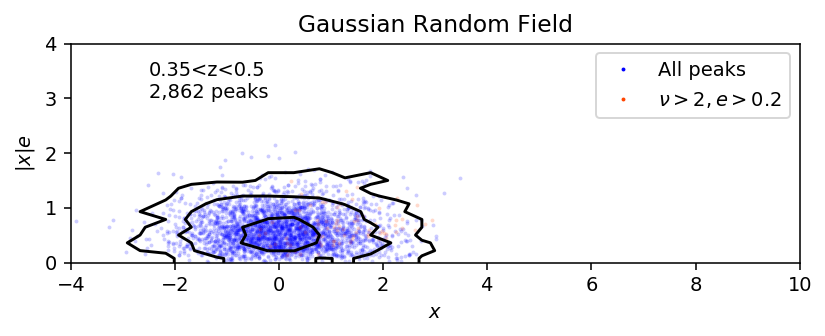

In [64]:
fig, ax = plt.subplots(1,1, figsize=[6, 2.5])


e  = zbin[:,3]
x  = zbin[:,4]
nu = zbin[:,5]
allowed = (nu > 2) & (e > 0.2)

ax.set_title("Gaussian Random Field")
#     ax[c].scatter(nu[highnu], e_highnu*abs(x_highnu), s=3, alpha = 0.05, label=r"$\nu_high$")
corner.hist2d(x[np.invert(allowed)],abs(x[np.invert(allowed)])*e[np.invert(allowed)], plot_datapoints=True,  levels=(0.39, 0.86, 0.99), fig=fig, ax=ax, plot_density=False, bins=15, no_fill_contours=True, color='k',  labels=[r'$\nu$',r'$|x|e$'], contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':0.2, 'color':'b', 'label':'All peaks'})
corner.hist2d(x[allowed],abs(x[allowed])*e[allowed], plot_datapoints=True,  levels=(0.39, 0.86, 0.99), fig=fig, ax=ax, plot_contours=False, plot_density=False, bins=15, no_fill_contours=True, color='k',  labels=[r'$\nu$',r'$|x|e$'], contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':0.2, 'color':'orangered', 'label':r'$\nu>2, e>0.2$'})
ax.set_xlabel(r"$x$")
ax.text(-2.5, 3, "0.35<z<0.5\n{:,} peaks".format(len(e)))
ax.set_ylabel("$|x|e$")
ax.set_ylim([0,4])
ax.set_xlim([-4,10])
#     ax[c].plot([0,0],[0,4])
#     ax[c].plot([2,2],[0,4], linestyle='--', color='k')
leg = ax.legend()
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
if thresh==True:
    thr = 'thr'
else:
    thr = 'nothr'
plt.tight_layout()
# plt.savefig("/home/mlokken/actxdes_stacking/plots/field_statistics/x_xe_nugt2_egtpt2_{:s}_zbin2_{:s}_alldes_9pt4overh_Mpc_{:s}_hess.png".format(mode, pks, thr), dpi=300)


In [3]:
bin_num = 3
peaks_data = np.loadtxt(os.path.join("/mnt/scratch-lustre/mlokken/stacking/ACT+Planck/", "grf_comparison_zbin{:d}_pkinfo_9pt4Mpc.txt".format(bin_num)))

peaks_grf  = np.loadtxt(os.path.join("/mnt/scratch-lustre/mlokken/stacking/GRF_buzzspec/0/", "grf_comparison_zbin{:d}_pkinfo_9pt4Mpc_gfieldpks.txt".format(bin_num)))
peaks_buzz = np.loadtxt(os.path.join("/mnt/scratch-lustre/mlokken/stacking/Buzzard_tSZ_rmpks/", "grf_comparison_zbin{:d}_pkinfo_9pt4Mpc.txt".format(bin_num)))
peaks_data_idx = np.random.choice(range(len(peaks_data)), replace=False, size=len(peaks_buzz))
# peaks_grf_idx  = np.random.choice(range(len(peaks_grf)), replace=False, size=len(peaks_buzz))
peaks_data = peaks_data[peaks_data_idx]
# peaks_grf  = peaks_grf[peaks_grf_idx]


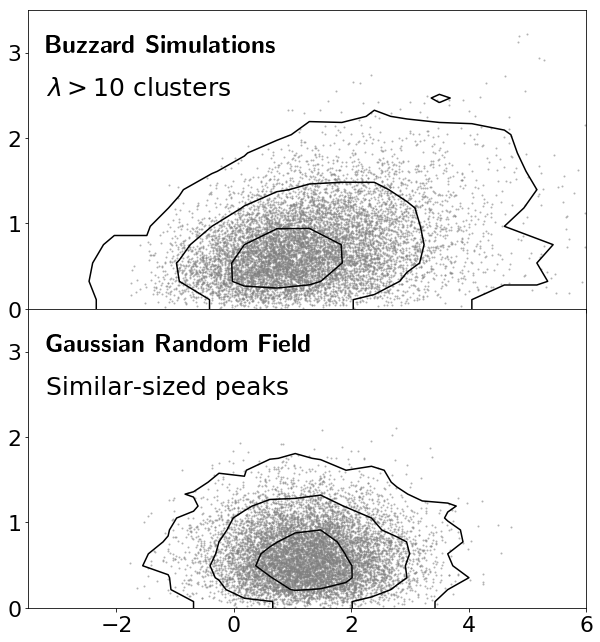

In [43]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(2,1, sharex=True, figsize=[10,11])

nu_data = peaks_data[:,5]
e_data  = peaks_data[:,3]
x_data  = peaks_data[:,4]
nu_grf = peaks_grf[:,5]
e_grf  = peaks_grf[:,3]
x_grf  = peaks_grf[:,4]
nu_buzz = peaks_buzz[:,5]
e_buzz  = peaks_buzz[:,3]
x_buzz  = peaks_buzz[:,4]
allowed_data = (nu_data>2) & (e_data>0.3)
allowed_buzz = (nu_buzz>2) & (e_buzz>0.3)
allowed_grf  = (nu_grf>2) & (e_grf>0.3)

# corner.hist2d(nu_data,abs(x_data)*e_data, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[0], plot_density=False, bins=15, no_fill_contours=True, color='k', contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':.6, 'color':'grey'})
# corner.hist2d(nu_data[allowed_data],abs(x_data[allowed_data])*e_data[allowed_data], plot_contours=False, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[0], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'markersize':3, 'alpha':1, 'color':'red', 'label':r'$\nu>2, e>0.3$'})
corner.hist2d(nu_buzz,abs(x_buzz)*e_buzz, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[0], plot_density=False, bins=15, no_fill_contours=True, color='k', contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':.6, 'color':'grey'})
# corner.hist2d(nu_buzz[allowed_buzz],abs(x_buzz[allowed_buzz])*e_buzz[allowed_buzz],plot_contours=False,  plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[1], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'markersize':3, 'alpha':1, 'color':'red', 'label':r'$\nu>2, e>0.3$'})
corner.hist2d(nu_grf,abs(x_grf)*e_grf, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[1], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':.6, 'color':'grey', })
# corner.hist2d(nu_grf[allowed_grf],abs(x_grf[allowed_grf])*e_grf[allowed_grf], plot_contours=False, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[2], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'markersize':3, 'alpha':1, 'color':'red', 'label':r'$\nu>2, e>0.3$'})
titles = ["Buzzard Simulations", "Gaussian Random Field"]

e = [len(e_data), len(e_buzz), len(e_grf)]
pks = ["$\lambda>10$ clusters", "Similar-sized peaks"]
for c in range(2):
#     ax[c].set_title(titles[c])
    ax[c].text(-3.2, 3.0, "\\textbf{{{:s}}}".format(titles[c]), usetex=True, fontsize=25)
    ax[c].text(-3.2, 2.5, "{:s}".format(pks[c]), fontsize=25)
    
    
# plt.ylabel(r"$|x|e$ (Field elongation)")

# ax[1].set_xlabel(r"$\nu$ (Field excursion)")

plt.xlim([-3.5, 6])
for a in ax:
    a.set_ylim([0,3.5])
plt.subplots_adjust(hspace=0)    
# fig.tight_layout()

# plt.savefig("/home/mlokken/oriented_stacking/plots/field_statistics/3panel_buzz_grf_xe_vs_nu_zbin2_forcasca.png")

number remaining after cuts, Buzzard: 1366
percentage remaining after cuts 9.837950862519602 11.311596496781682


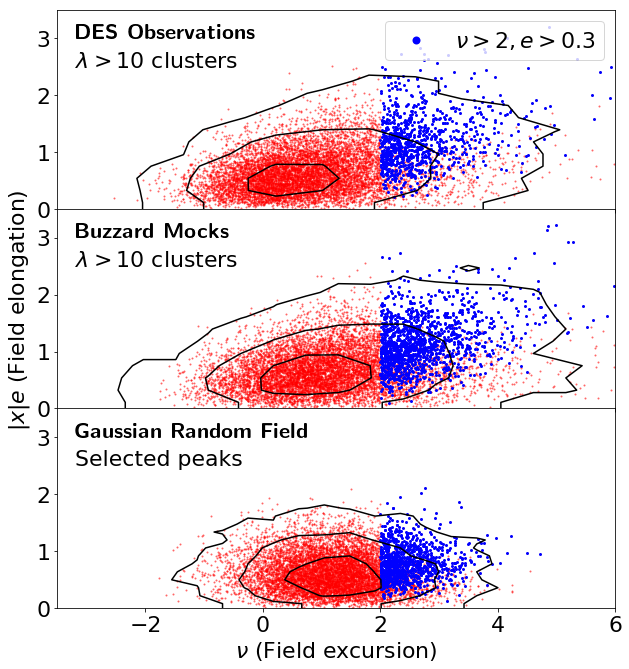

In [4]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(3,1, sharex=True, figsize=[10,11])

nu_data = peaks_data[:,5]
e_data  = peaks_data[:,3]
x_data  = peaks_data[:,4]
nu_grf = peaks_grf[:,5]
e_grf  = peaks_grf[:,3]
x_grf  = peaks_grf[:,4]
nu_buzz = peaks_buzz[:,5]
e_buzz  = peaks_buzz[:,3]
x_buzz  = peaks_buzz[:,4]
allowed_data = (nu_data>2) & (e_data>0.3)
allowed_buzz = (nu_buzz>2) & (e_buzz>0.3)
allowed_grf  = (nu_grf>2) & (e_grf>0.3)

corner.hist2d(nu_data,abs(x_data)*e_data, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[0], plot_density=False, bins=15, no_fill_contours=True, color='k', contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':.6, 'color':'red'})
corner.hist2d(nu_data[allowed_data],abs(x_data[allowed_data])*e_data[allowed_data], plot_contours=False, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[0], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'markersize':3, 'alpha':1, 'color':'blue', 'label':r'$\nu>2, e>0.3$'})
corner.hist2d(nu_buzz,abs(x_buzz)*e_buzz, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[1], plot_density=False, bins=15, no_fill_contours=True, color='k', contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':.6, 'color':'red'})
corner.hist2d(nu_buzz[allowed_buzz],abs(x_buzz[allowed_buzz])*e_buzz[allowed_buzz],plot_contours=False,  plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[1], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'markersize':3, 'alpha':1, 'color':'blue', 'label':r'$\nu>2, e>0.3$'})
corner.hist2d(nu_grf,abs(x_grf)*e_grf, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[2], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':.6, 'color':'red', })
corner.hist2d(nu_grf[allowed_grf],abs(x_grf[allowed_grf])*e_grf[allowed_grf], plot_contours=False, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[2], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'markersize':3, 'alpha':1, 'color':'blue', 'label':r'$\nu>2, e>0.3$'})
titles = ["DES Observations", "Buzzard Mocks", "Gaussian Random Field"]

e = [len(e_data), len(e_buzz), len(e_grf)]
pks = ["$\lambda>10$ clusters", "$\lambda>10$ clusters", "Selected peaks"]
for c in range(3):
#     ax[c].set_title(titles[c])
    ax[c].text(-3.2, 3.0, "\\textbf{{{:s}}}".format(titles[c]), usetex=True)
    ax[c].text(-3.2, 2.5, "{:s}".format(pks[c]))
    

ax[1].set_ylabel(r"$|x|e$ (Field elongation)")
leg = ax[0].legend(loc='upper right')
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_markersize(8)

ax[2].set_xlabel(r"$\nu$ (Field excursion)")

print("number remaining after cuts, Buzzard:", len(nu_buzz[allowed_buzz]))
print("percentage remaining after cuts", len(nu_data[allowed_data])/len(nu_data)*100, len(nu_grf[allowed_grf])/len(nu_grf)*100)
plt.xlim([-3.5, 6])
for a in ax:
    a.set_ylim([0,3.5])
plt.subplots_adjust(hspace=0)
# fig.tight_layout()

plt.savefig("/home/mlokken/oriented_stacking/plots/field_statistics/3panel_des_buzz_grf_xe_vs_nu_zbin2.png")

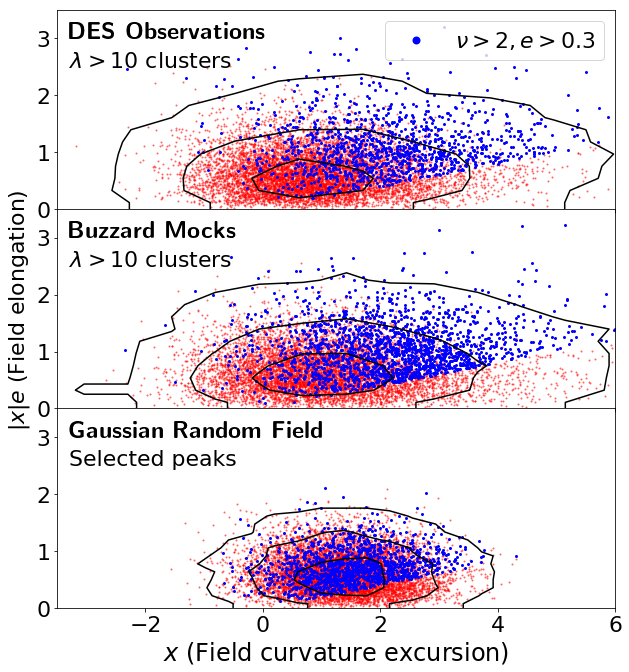

In [6]:


fig, ax = plt.subplots(3,1, sharex=True, figsize=[10,11])
nu_data = peaks_data[:,5]
e_data  = peaks_data[:,3]
x_data  = peaks_data[:,4]
nu_grf = peaks_grf[:,5]
e_grf  = peaks_grf[:,3]
x_grf  = peaks_grf[:,4]
nu_buzz = peaks_buzz[:,5]
e_buzz  = peaks_buzz[:,3]
x_buzz  = peaks_buzz[:,4]
allowed_data = (nu_data>2) & (e_data>0.2)
allowed_buzz = (nu_buzz>2) & (e_buzz>0.2)
allowed_grf  = (nu_grf>2) & (e_grf>0.2)

corner.hist2d(x_data,abs(x_data)*e_data, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[0], plot_density=False, bins=15, no_fill_contours=True, color='k', contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':0.6, 'color':'red'})
corner.hist2d(x_data[allowed_data],abs(x_data[allowed_data])*e_data[allowed_data], plot_contours=False, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[0], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'markersize':3, 'alpha':1, 'color':'blue', 'label':r'$\nu>2, e>0.3$'})
corner.hist2d(x_buzz,abs(x_buzz)*e_buzz, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[1], plot_density=False, bins=15, no_fill_contours=True, color='k', contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':0.6, 'color':'red'})
corner.hist2d(x_buzz[allowed_buzz],abs(x_buzz[allowed_buzz])*e_buzz[allowed_buzz],plot_contours=False,  plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[1], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'markersize':3, 'alpha':1, 'color':'blue', 'label':r'$\nu>2, e>0.3$'})
corner.hist2d(x_grf,abs(x_grf)*e_grf, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[2], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'alpha':0.6, 'color':'red'})
corner.hist2d(x_grf[allowed_grf],abs(x_grf[allowed_grf])*e_grf[allowed_grf], plot_contours=False, plot_datapoints=True, levels=(0.39, 0.86, 0.99), fig=fig, ax=ax[2], plot_density=False, bins=15, no_fill_contours=True, color='k',  contour_kwargs = {'colors':'k'}, data_kwargs={'markersize':3, 'alpha':1, 'color':'blue', 'label':r'$\nu>2, e>0.3$'})
titles = ["DES Observations", "Buzzard Mocks", "Gaussian Random Field"]

e = [len(e_data), len(e_buzz), len(e_grf)]
pks = ["$\lambda>10$ clusters", "$\lambda>10$ clusters", "Selected peaks"]
for c in range(3):
#     ax[c].set_title(titles[c])
    ax[c].text(-3.3, 3.0, "\\textbf{{{:s}}}".format(titles[c]), usetex=True, fontsize=24)
    ax[c].text(-3.3, 2.5, "{:s}".format(pks[c]))
    
ax[1].set_ylabel(r"$|x|e$ (Field elongation)")

leg = ax[0].legend(loc='upper right')
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_markersize(8)

ax[2].set_xlabel(r"$x$ (Field curvature excursion)", fontsize=24)
plt.subplots_adjust(hspace=0)


plt.xlim([-3.5, 6])
for a in ax:
    a.set_ylim([0,3.5])
# plt.tight_layout()
plt.savefig("/home/mlokken/oriented_stacking/plots/field_statistics/3panel_des_buzz_grf_xe_vs_x_zbin2.png")

In [35]:
if mode == 'buzzard':
    od_map_smooth = read_amp_map("/mnt/scratch-lustre/mlokken/buzzard/number_density_maps/des_reg/buzzard_redmagic_highdens_lowz_od_map_nosmooth_4096_AMPLITUDE_fwhm{:s}a.fits".format(smth_scale))
elif mode == 'grf':
#     od_map_smooth = read_amp_map("/mnt/scratch-lustre/mlokken/stacking/gal_GRF/grf_pandeyfit_rmagic_gg_zbin1_wmask_AMPLITUDE_fwhm{:s}a.fits".format(smth_scale))

    #     od_map_smooth = read_amp_map("/mnt/scratch-lustre/mlokken/stacking/gal_GRF/grf_pandeyfit_rmagic_gg_zbin1_AMPLITUDE_fwhm{:s}a.fits".format(smth_scale))
#     od_map_flat = hp.cartview(od_map_smooth, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E')
    od_map = hp.read_map("/mnt/scratch-lustre/mlokken/stacking/gal_GRF/grf_pandeyfit_rmagic_gg_zbin1.fits")
    od_map_smooth = hp.smoothing(od_map, sigma = R_ang_low.to(u.rad).value)
elif mode == 'redmagic':
    od_map_smooth = read_amp_map("/mnt/scratch-lustre/mlokken/data/number_density_maps/3_zbins_grf_comparison/7pt5overh_Mpc/redmagic_highdens_zbin1_od_map_nosmooth_AMPLITUDE_fwhm41pt1224a.fits")
    ecc_map = hp.read_map("/mnt/scratch-lustre/mlokken/data/number_density_maps/3_zbins_grf_comparison/redmagic_highdens_zbin1_od_map_nosmooth_ECC_HESSIAN_fwhm36pt5959a.fits", field=0)
od_map_flat   = hp.cartview(od_map_smooth, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E')
ecc_map_flat  = hp.cartview(ecc_map, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E')

NameError: name 'mode' is not defined

In [ ]:
if mode == 'buzzard' or mode=='grf':
#     mask = hp.read_map("/mnt/scratch-lustre/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")
    mask = np.ones(hp.nside2npix(nside))
    all_pix = np.arange(hp.nside2npix(nside))
    lon,lat = hp.pix2ang(nside, all_pix, lonlat=True)
    lat_cond = np.logical_or(lat < latmin, lat > latmax)
    lon_cond = np.logical_or(lon < lonmin, lon > lonmax)
    masked_pix = all_pix[np.logical_or((lat_cond), (lon_cond))]
    mask[masked_pix] = 0.
    hp.mollview(mask)
    od_map_masked = od_map_smooth * mask
# elif mode == 'grf':
#     mask = np.ones(hp.nside2npix(nside))

In [ ]:
hp.mollview(od_map_smooth)

In [ ]:
# There are 2 definitions of rms. One subtracts the mean from each number before squaring and summing.
# This seems to be the version that COOP does

mean_od = sum(od_map_smooth*mask)/sum(mask)
rms = np.sqrt(sum((od_map_smooth-mean_od)**2*mask)/sum(mask))
print("rms = ", rms)
print("mean of overdensity map = ", mean_od)
nu = ((od_map_smooth-mean_od)*mask) / rms
hp.mollview(nu)

In [ ]:
# do thresholding
cl_pix = hp.ang2pix(nside, ra, dec, lonlat=True)
cl_pix_th = [] # peaks above threshold 1.686 with large filtering scale
i = 0
idx = []
for pix in cl_pix:
    if nu[pix]>1.5:
        cl_pix_th.append(pix)
        idx.append(i)
    i += 1
print(len(cl_pix))
print(len(cl_pix_th))

In [ ]:
cl_nu  = nu[cl_pix_th]
e_vals = e_vals[idx]

In [20]:
mpl.rcParams['figure.figsize'] = [5.0, 5.0]
mpl.rcParams['figure.dpi'] = 140
plt.scatter(allz_peaks_info[:,], e_vals, s=5, alpha = 0.2)
plt.xlabel(r"$\nu$")
plt.ylabel("e")
# plt.xlim([2.5, 11])
plt.title("nu-e map for {:s}, {:s}'".format(mode, smth_scale))
# plt.ylim([0,10])
plt.xlim([-6,6])
# plt.savefig("/home/mlokken/actxdes_stacking/plots/nu_e_{:s}_zbin1_36a_hess_ylim.png".format(mode), dpi=300)


NameError: name 'cl_nu' is not defined

In [ ]:
plt.hist(nu[cl_pix], bins=4)
plt.xlabel(r"$\nu$")
plt.ylabel("$N_{cluster}$")
plt.xlim([-1, 29])

In [14]:
w = wcs.WCS(naxis=2)

height = float(od_map_flat.shape[0])
length = float(od_map_flat.shape[1])
w = wcs.WCS(naxis=2)
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmin-latmax)/height, (latmin+latmax)/2.


w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]

[400. 125.]
[ 19. -34.]
[-0.04 -0.04]


In [15]:
Xpix,Ypix = w.all_world2pix(allz_peaks_info[0][:,1],allz_peaks_info[0][:,2],0)

In [16]:
xlims = w.all_world2pix([0,10], [-5,-5], 0)
ylims = w.all_world2pix([10,10], [-5,5], 0)

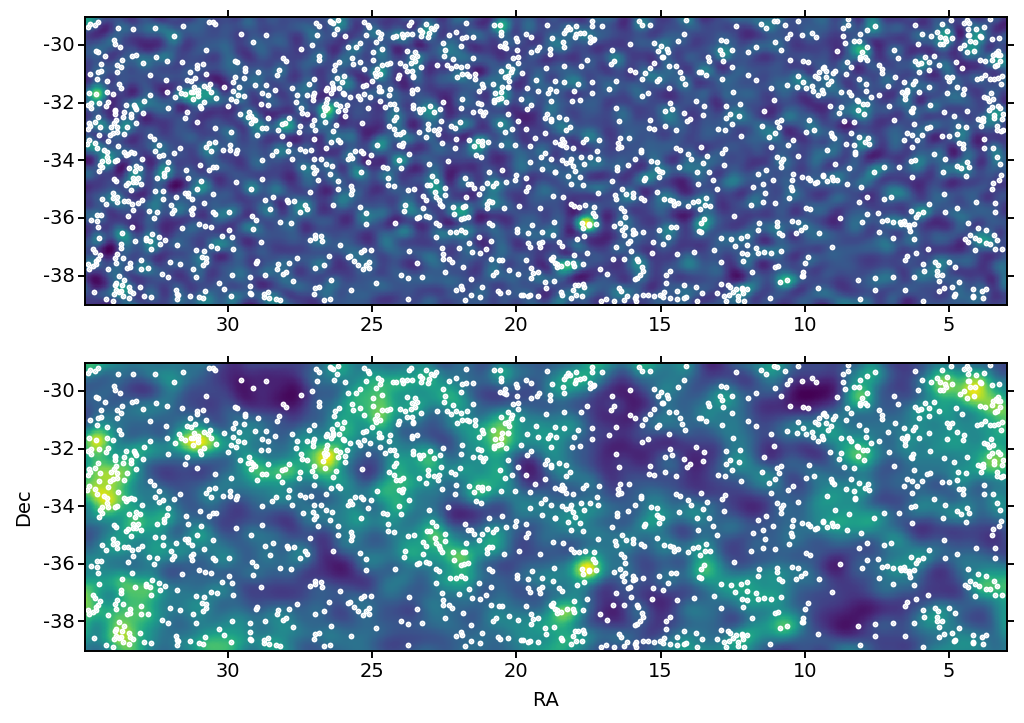

In [22]:
# Make the figure

fig = plt.figure(figsize=(15,6))


mpl.rcParams['figure.figsize'] = [10.0, 5.0]
mpl.rcParams['figure.dpi'] = 140

nrows = 2
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax2 = plt.subplot(nrows, 1, 2, projection=w)
ax1.imshow(ecc_map_flat[::-1])
ax1.set_xticks([])
ax1.set_xticklabels([])

ax2.imshow(od_map_flat[::-1])
U_arr, V_arr = get_vector_components(allz_peaks_info[0][:,0])
# ax1.quiver(Xpix,Ypix, -U_arr, V_arr, width=0.0025, color = '.6', scale_units = 'inches', scale = 5)
# ax1.quiver(Xpix,Ypix, U_arr, -V_arr, width=0.0025, color = '.6', scale = 5, scale_units = 'inches')

cm = mpl.cm.get_cmap('Oranges')
s = ax1.scatter(Xpix,Ypix, linewidths=2, s=1, color='white')
s = ax2.scatter(Xpix,Ypix, linewidths=2, s=1, color='white')
ax2.set_xlabel("RA")
ax2.set_ylabel("Dec")
plt.savefig("/home/mlokken/actxdes_stacking/plots/field_statistics/redmagic_w_rmappercls_zbin1_odmap_7pt5overhMpc_xmap_nothr_alle_hess.png", dpi=300)